In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import talib
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv()

True

In [3]:
ticker = ["SPY"]
# Set timeframe to "1Day" for Alpaca API
timeframe = "1day"
# Format current date as ISO format
start_date = pd.Timestamp("2019-01-06", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-01-28", tz="America/New_York").isoformat()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)


stock_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
# Drop unwanted coloumns - Keep  Close
stock_data.drop(columns= ['trade_count','vwap','symbol'], inplace= True)
    # Combine individual stocks into a single data frame

  # Rename the coloumns to the ticker symbols in the list
#stock_data.columns = ticker
stock_data.index.name = 'Date'
stock_data.index_column = 'Date'
# Drop the N/As


# Drop the time component of the date
#df_ticker.index = df_ticker.index.date


# Display the data
display(stock_data)

,open,high,low,close,volume
Date,,,,,
2019-01-07 05:00:00+00:00,252.700,255.9500,251.69,254.29,103705813
2019-01-08 05:00:00+00:00,256.820,257.3100,254.00,256.62,103267687
2019-01-09 05:00:00+00:00,257.560,258.9100,256.19,257.92,95741225
2019-01-10 05:00:00+00:00,256.260,259.1600,255.50,258.98,98012473
2019-01-11 05:00:00+00:00,257.680,259.0098,257.03,258.81,74684741
...,...,...,...,...,...
2023-01-23 05:00:00+00:00,396.720,402.6450,395.72,400.63,84187957
2023-01-24 05:00:00+00:00,398.880,401.1500,397.64,400.20,59549719
2023-01-25 05:00:00+00:00,395.950,400.7000,393.56,400.35,84826825


In [4]:
stock_data.dropna(inplace=True)

In [5]:
# Set the variables for short window and long window periods
short_window = 8
long_window = 20
# Add additional columns for EMA
stock_data["EMA_8"] = stock_data["close"].ewm(span=short_window).mean()
stock_data["EMA_20"] = stock_data["close"].ewm(span=long_window).mean()

In [6]:
stock_data["MA_50"] = stock_data["close"].rolling(window=50).mean()
stock_data["MA_126"] = stock_data["close"].rolling(window=126).mean()

In [7]:
# Add additional columns for RSI
stock_data["RSI"] = talib.RSI(stock_data["close"])


In [8]:
# Add additional columns for Bollinger Bands
stock_data["Upper_Bollinger_Band"], stock_data["Middle_Bollinger_Band"], stock_data["Lower_Bollinger_Band"] = talib.BBANDS(stock_data["close"])

In [9]:
# Shift the data by 10 days
stock_data["Close_future_10"] = stock_data["close"].shift(-10)

In [10]:
#check for any missing values
stock_data.isnull().sum()

open                       0
high                       0
low                        0
close                      0
volume                     0
EMA_8                      0
EMA_20                     0
MA_50                     49
MA_126                   125
RSI                       14
Upper_Bollinger_Band       4
Middle_Bollinger_Band      4
Lower_Bollinger_Band       4
Close_future_10           10
dtype: int64

In [11]:
#handle missing values
stock_data.fillna(stock_data.mean(), inplace=True)

In [12]:
# Split the data into training and test sets
X = stock_data[["open", "high", "low", "close", "volume","MA_126","MA_50", "EMA_8", "EMA_20", "RSI", "Upper_Bollinger_Band", "Middle_Bollinger_Band", "Lower_Bollinger_Band"]]
y = stock_data["Close_future_10"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)


In [13]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
#Initialize the models
linear_regression = LinearRegression()
svr = SVR()
random_forest = RandomForestRegressor(n_estimators=10)


In [15]:
# Create a voting regressor that combines the predictions of the individual models
voting_regressor = VotingRegressor(estimators=[('linear_regression', linear_regression),
                                               ('svr', svr),
                                               ('random_forest', random_forest)])

# Fit the voting regressor to the training data
voting_regressor.fit(X_train, y_train)


VotingRegressor(estimators=[('linear_regression', LinearRegression()),
                            ('svr', SVR()),
                            ('random_forest',
                             RandomForestRegressor(n_estimators=10))])

In [16]:
#Make predictions on the test set
y_pred = voting_regressor.predict(X_test)

In [17]:
#Evaluate the models
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R-squared Score: ", r2)

Mean Squared Error:  153.9423391038629
R-squared Score:  0.9563740936934793


In [18]:
# Define the parameter grid for the random forest regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
#Hyperparameters of the models in the voting regressor
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search_rf.fit(X_train, y_train.ravel())
print("Best Parameters: ", grid_search_rf.best_params_)

Best Parameters:  {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}


In [19]:
# Use the best parameters to fit the random forest regressor
rf_best = RandomForestRegressor(**grid_search_rf.best_params_)
rf_best.fit(X_train, y_train.ravel())


RandomForestRegressor(max_depth=9, min_samples_split=6)

In [20]:
#Make predictions
y_pred = voting_regressor.predict(X_test)
y_pred 

array([343.2334498 , 399.07261431, 399.86635981, 412.99807853,
       287.95090332, 403.02600285, 435.26389207, 318.13178848,
       390.24525734, 438.94552635, 350.13392624, 291.87502603,
       356.49837568, 392.86642898, 336.01572288, 347.02317972,
       383.96831856, 368.01105248, 298.44448874, 298.80085582,
       412.1516651 , 391.46680982, 382.3562686 , 329.4629669 ,
       404.19007724, 343.45844576, 394.68516596, 401.34595167,
       299.71454933, 451.5381192 , 448.54240064, 450.61561534,
       437.1233192 , 291.86142154, 344.0992138 , 293.15280333,
       447.82107948, 427.46080923, 451.43417562, 283.33567438,
       292.15427141, 281.5401914 , 453.71438065, 286.52131216,
       437.98640449, 299.80400281, 312.62475497, 310.99758988,
       292.67713162, 443.58568218, 382.25169335, 306.07992353,
       300.19885042, 398.84519928, 435.35000954, 371.86377686,
       444.60582094, 318.36465106, 422.90772562, 349.19579155,
       301.81624584, 341.00486374, 305.62725748, 410.56

In [21]:
#Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  153.9423391038629


In [22]:
#Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score: ", r2)

R^2 Score:  0.9563740936934793


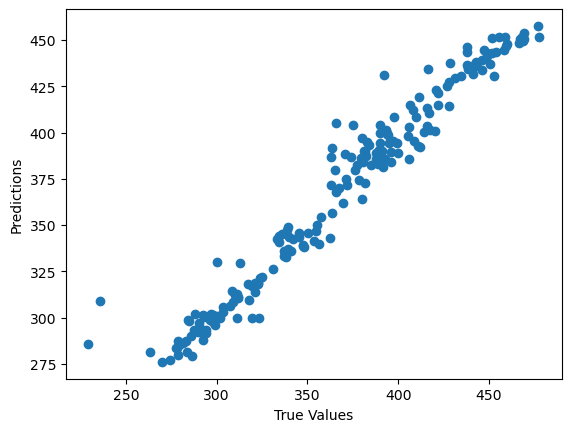

In [23]:

# Make predictions on the test set
y_pred = voting_regressor.predict(X_test)

# Plot the true values against the predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [24]:
# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

ValueError: continuous is not supported